In [19]:
from skimage import io
import plotly.express as px
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [20]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model7/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [21]:
def find_contours(dimensions, img) :
    
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour3.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intHeight > lower_height and intHeight < upper_height and intWidth < upper_width:
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 1)
            #plt.imshow(ii)
            # Make result formatted for classification: invert colors
            #char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
    #plt.show()
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
        # plt.imshow(img_res[idx], cmap='gray')
        # plt.show()
    img_res = np.array(img_res_copy)

    return img_res

In [22]:
def custom(result_image):
    LP_HEIGHT, LP_WIDTH = result_image.shape
    dimensions = [LP_WIDTH/15,
                    LP_WIDTH/2,
                    LP_HEIGHT/4,
                    LP_HEIGHT]
    p = find_contours(dimensions, result_image)
    
    
    for i in range(len(p)):
        plt.subplot(1, len(p)+1, i+1)
        plt.imshow(p[i], cmap='gray')
        plt.axis('off') 

In [23]:
def printing(result):
    for i in result:
        print(''.join(e for e in i[-1] if e.isalnum()), end=' ')
    print()

In [24]:
from skimage.segmentation import clear_border

def extract_text(image,bbox):
    # fig = px.imshow(image)
    # fig.show()
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    if 0 in roi.shape:
        return 'no number'
    else:

        img_gray_lp = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        cv2.fastNlMeansDenoising(img_gray_lp, img_gray_lp)
        cv2.imwrite('contour.jpg', roi)
        plt.imshow(img_gray_lp, cmap='gray')
        plt.show()
        
        img_binary_lp = cv2.adaptiveThreshold(img_gray_lp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,27,1)

        img_gray_lp = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        inve = cv2.threshold(img_gray_lp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        result_image = cv2.bitwise_and(img_gray_lp, img_gray_lp, mask=inve)
        result_image = clear_border(result_image)
        h, w = result_image.shape
        for i in range(h):
            for j in range(w):
                if result_image[i, j] > 130:
                    result_image[i, j] = 255
        
        plt.imshow(result_image, cmap='gray')
        plt.show()
        cv2.imwrite('contour3.jpg', result_image)
        
        img_gray_lp = cv2.bitwise_not(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY))
        inve = cv2.threshold(img_gray_lp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        result_image = cv2.bitwise_and(img_gray_lp, img_gray_lp, mask=inve)
        result_image = clear_border(result_image)
        #plt.imshow(result_image, cmap='gray')
        #plt.show()
        cv2.imwrite('contour4.jpg', result_image)
        
        inv = cv2.threshold(img_binary_lp, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        inv = clear_border(inv)
        inv = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #plt.imshow(inv, cmap='gray')
        #plt.show()
        cv2.imwrite('contour1.jpg', inv)
        custom(inv)
        
        inv = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        cv2.imwrite('contour2.jpg', inv)
        #plt.imshow(roi, cmap='gray')
        #plt.show()
        # EascyOCR
        result = reader.readtext('./contour.jpg',paragraph="False")
        printing(result)
        result = reader.readtext('./contour3.jpg',paragraph="False")
        printing(result)
        result = reader.readtext('./contour4.jpg',paragraph="False")
        printing(result)
        result = reader.readtext('./contour1.jpg',paragraph="False")
        printing(result)
        result = reader.readtext('./contour2.jpg',paragraph="False")
        printing(result)
    
        return result
        

In [25]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.3:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    if len(index) == 0:
        cv2.imwrite('contour.jpg', image)
        LP_WIDTH = image.shape[0]
        LP_HEIGHT = image.shape[1]
        dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
        #print(find_contours(dimensions, cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)))
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])

        #print(image)
        image = cv2.rectangle(np.float32(image),(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        #cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.56,(0,0,0),2)
        #cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)
    return image

In [26]:
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img


In [27]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


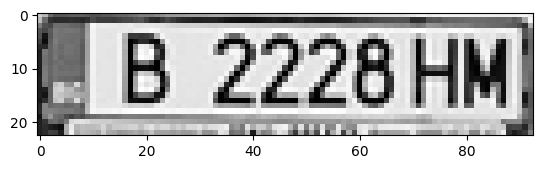

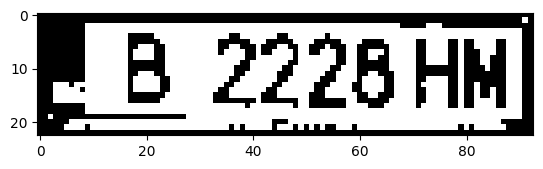

B2228HM 
B2228HH 
B2228HM 
B2228HH 
B2228HM 


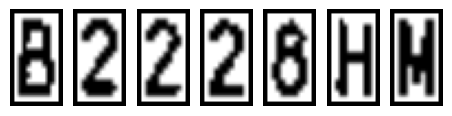

In [39]:
# test
#img = io.imread('./test/Cars57.png')[:,:,:3]
#img = io.imread('./test/MicrosoftTeams-image(1).jpeg')[:,:,:3]
#img = io.imread('./archive/images/00000340.jpg')[:,:,:3]
img = io.imread('./img/4.png')[:,:,:3]
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

# fig.show()
results = yolo_predictions(img,net)

In [36]:
fig = px.imshow(results)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()